In [1]:
import h5py
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import openslide
import matplotlib.pyplot as plt

In [2]:
def eval_transforms(pretrained=False):
    if pretrained:
        mean = (0.485, 0.456, 0.406)
        std = (0.229, 0.224, 0.225)

    else:
        mean = (0.5,0.5,0.5)
        std = (0.5,0.5,0.5)

    trnsfrms_val = transforms.Compose([transforms.ToTensor(),
#                                        transforms.Normalize(mean = mean, std = std)
                                      ])

    return trnsfrms_val

In [3]:
class Whole_Slide_Bag_FP(Dataset):
	def __init__(self,
		file_path,
		wsi,
		pretrained=False,
		custom_transforms=None,
		custom_downsample=1,
		target_patch_size=-1
		):
		"""
		Args:
			file_path (string): Path to the .h5 file containing patched data.
			pretrained (bool): Use ImageNet transforms
			custom_transforms (callable, optional): Optional transform to be applied on a sample
			custom_downsample (int): Custom defined downscale factor (overruled by target_patch_size)
			target_patch_size (int): Custom defined image size before embedding
		"""
		self.pretrained=pretrained
		self.wsi = wsi
		if not custom_transforms:
			self.roi_transforms = eval_transforms(pretrained=pretrained)
		else:
			self.roi_transforms = custom_transforms

		self.file_path = file_path

		with h5py.File(self.file_path, "r") as f:
			dset = f['coords']
			self.patch_level = f['coords'].attrs['patch_level']
			self.patch_size = f['coords'].attrs['patch_size']
			self.length = len(dset)
			if target_patch_size > 0:
				self.target_patch_size = (target_patch_size, ) * 2
			elif custom_downsample > 1:
				self.target_patch_size = (self.patch_size // custom_downsample, ) * 2
			else:
				self.target_patch_size = None
		self.summary()
			
	def __len__(self):
		return self.length

	def summary(self):
		hdf5_file = h5py.File(self.file_path, "r")
		dset = hdf5_file['coords']
		for name, value in dset.attrs.items():
			print(name, value)

		print('\nfeature extraction settings')
		print('target patch size: ', self.target_patch_size)
		print('pretrained: ', self.pretrained)
		print('transformations: ', self.roi_transforms)

	def __getitem__(self, idx):
		with h5py.File(self.file_path,'r') as hdf5_file:
			coord = hdf5_file['coords'][idx]
		img = self.wsi.read_region(coord, self.patch_level, (self.patch_size, self.patch_size)).convert('RGB')

		if self.target_patch_size is not None:
			img = img.resize(self.target_patch_size)
		img = self.roi_transforms(img).unsqueeze(0)
		return img, coord

In [4]:
wsi = openslide.open_slide('data/10930_chx_digestive_benigne/00000664-00746389-22HI045346-1-A1P-1.ndpi')
dataset = Whole_Slide_Bag_FP('preprocess/output/patches/00000664-00746389-22HI045346-1-A1P-1.h5', wsi)

dataloader = DataLoader(dataset, batch_size=64)

downsample [16. 16.]
downsampled_level_dim [4800 2016]
level_dim [4800 2016]
name 00000664-00746389-22HI045346-1-A1P-1
patch_level 4
patch_size 1280
save_path output/patches

feature extraction settings
target patch size:  None
pretrained:  False
transformations:  Compose(
    ToTensor()
)


In [5]:
imgs, coords = next(iter(dataloader))

In [7]:
new_img = imgs[0][0].transpose(0,1).transpose(1,2)

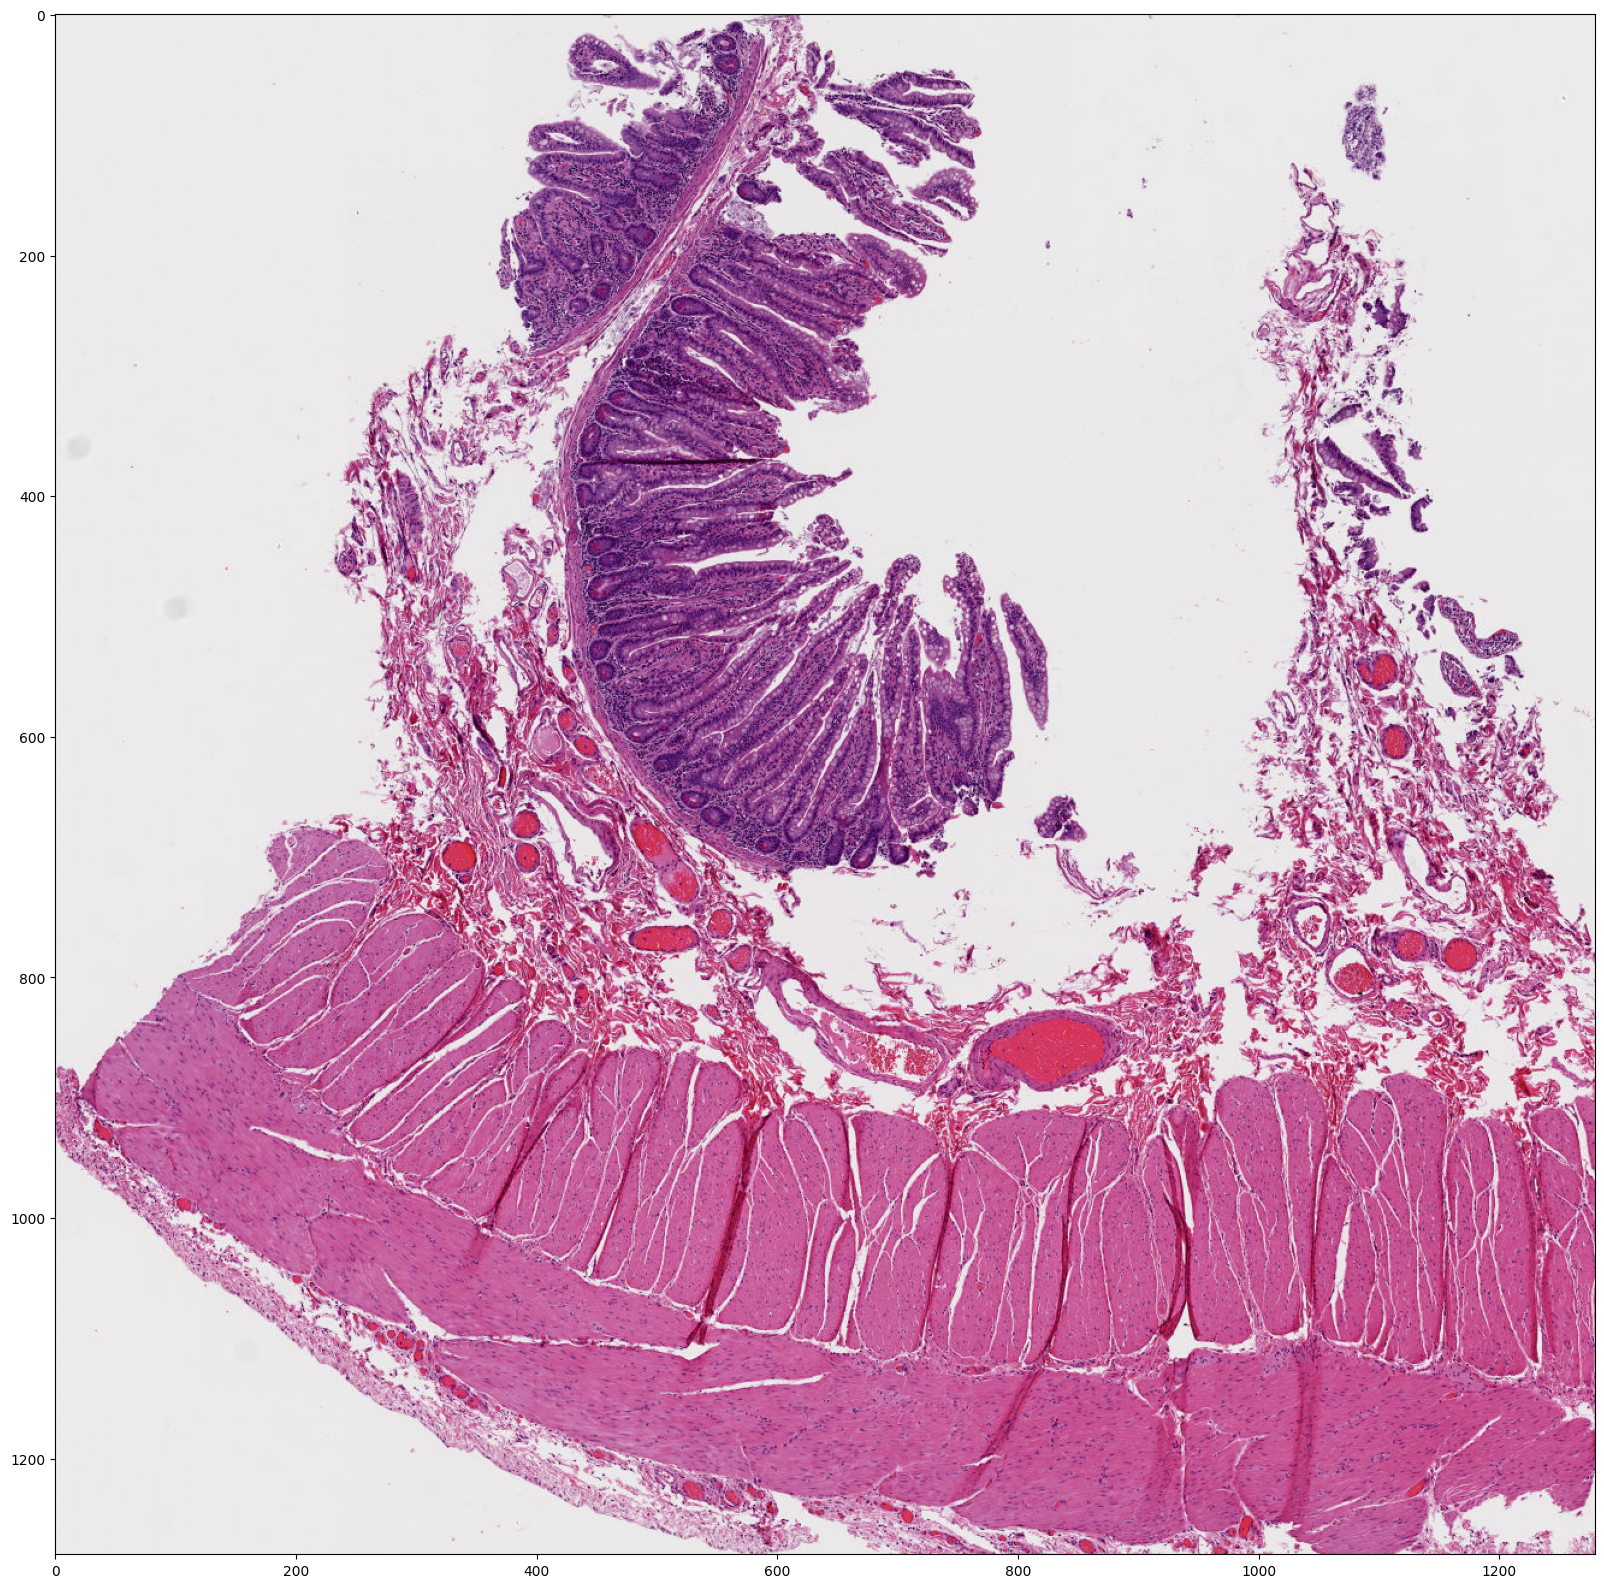

In [8]:
plt.figure(figsize=(20, 20))
plt.imshow(new_img)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

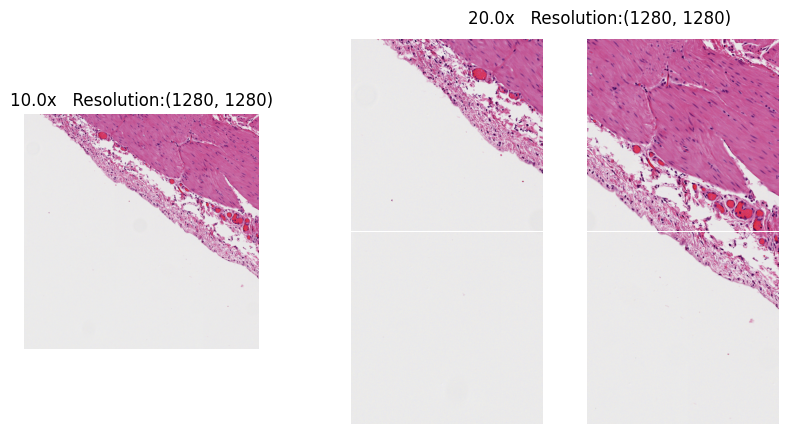

In [24]:
idx = 1
patch_size = 1280
x = {}

with h5py.File('preprocess/output/patches/00000664-00746389-22HI045346-1-A1P-1.h5','r') as hdf5_file:
    coords = list(hdf5_file['coords'])
    dset = hdf5_file['coords']
    for name, value in dset.attrs.items():
#         print(name, value)
        x[name] = value
patch_level = x['patch_level']
coord = coords[idx]
img = wsi.read_region(coord, patch_level, (patch_size, patch_size)).convert('RGB')
new_level_patch_size = patch_size*(2**(patch_level-1))
up_imgs = []
for i,j in [(0,0),(1, 0), (0, 1), (1, 1)]:
    new_coord = (coord[0]+i*new_level_patch_size, coord[1]+j*new_level_patch_size)
    up_imgs.append(wsi.read_region(new_coord, patch_level-1, (patch_size, patch_size)).convert('RGB'))

# Create figure
fig = plt.figure(figsize=(10, 5))

# Create a GridSpec with 1 row and 2 columns
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2])  # Adjust width ratios as needed

# The first subplot for the single image on the left
ax0 = plt.subplot(gs[0])
ax0.imshow(img)
ax0.set_title(f'{40/(2**patch_level)}x   Resolution:{img.size}')
ax0.axis('off')  # Hide axes for cleaner look

# The second subplot area for the 2x2 images on the right
right_subplot = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[1], wspace=0.01, hspace=0.01)

# Loop through the right images and display each
for i in range(4):
    ax = plt.subplot(right_subplot[i])
    ax.imshow(up_imgs[i])
#     ax.set_title(f'10x   Resolution:{img.size}')
    ax.axis('off')  # Hide axes for cleaner look
fig.text(0.7, 0.92, f'{40/(2**(patch_level-1))}x   Resolution:{img.size}', ha='center', va='center', fontsize=12)

# plt.tight_layout()
plt.show()
